In [1]:
import pandas as pd
import numpy as np
import featuretools as ft
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/Users/Bin/anaconda2/envs/py2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load data

In [2]:
train_df = pd.read_csv('/Users/Bin/Downloads/datasets/Titanic, Machine Learning from Disaster/train.csv', delimiter=',')
test_df = pd.read_csv('/Users/Bin/Downloads/datasets/Titanic, Machine Learning from Disaster/test.csv', delimiter=',')

In [3]:
# the result is Index
# train_df.columns
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

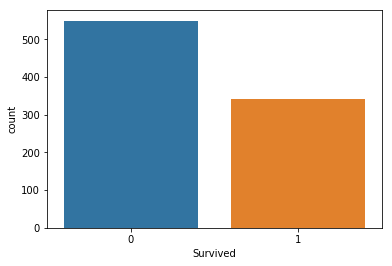

In [4]:
# check the proportion between positive and negative labels
sns.countplot(x='Survived', data=train_df)

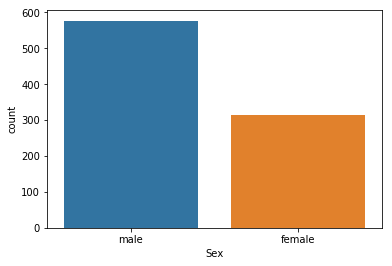

In [5]:
# cross around the result, the people who died or not, we can continue to consider the sex
sns.countplot(x='Sex', data=train_df)

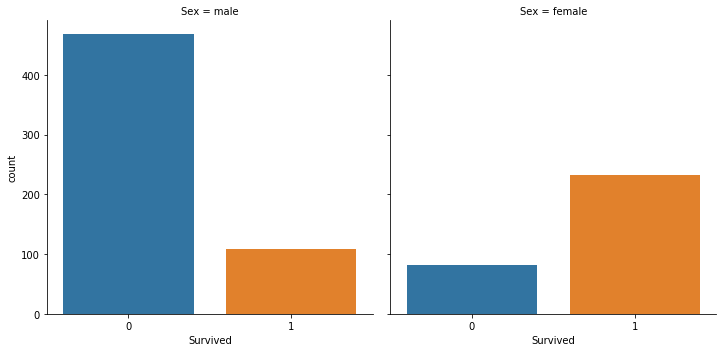

In [6]:
# survived or not in curtain gender
sns.factorplot(x='Survived', col='Sex', kind='count', data=train_df)

In [7]:
# chain a group by Sex, sum Survived
train_df.groupby('Sex')['Survived'].sum()

Sex
female    233
male      109
Name: Survived, dtype: int64

In [8]:
# calculate the ratio of survived/died to female and male respectively
print (float(train_df[train_df.Sex == 'female'].Survived.sum()) / train_df[train_df.Sex == 'female'].Survived.count())

print (float(train_df[train_df.Sex == 'male'].Survived.sum()) / train_df[train_df.Sex == 'male'].Survived.count())

0.742038216561
0.188908145581


In [9]:
print test_df.head()
print test_df.shape

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  
(418, 11)


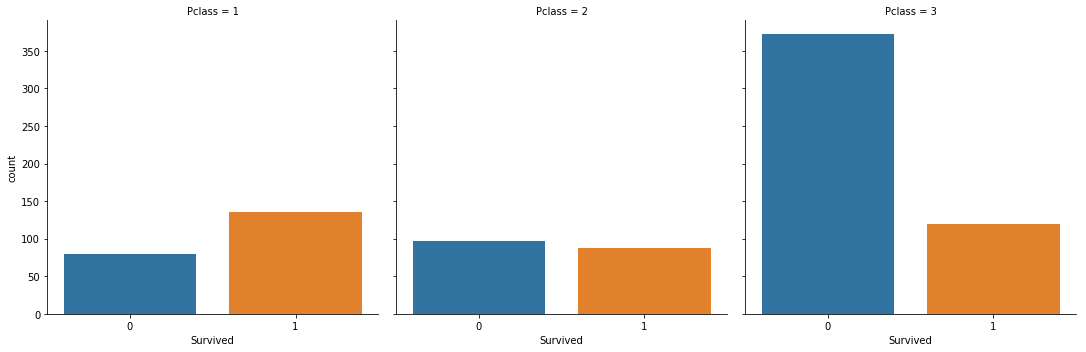

In [10]:
# explore the relationship between Survived and Pclass
sns.factorplot(x='Survived', col='Pclass', kind='count', data=train_df)

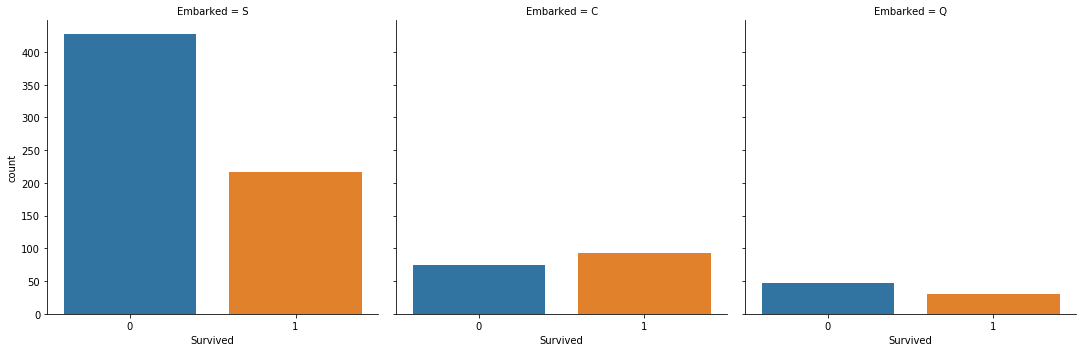

In [11]:
# explore the relationship between Survived and Embarked
sns.factorplot(x='Survived', col='Embarked', kind='count', data=train_df)

## EDA with Numeric Variables

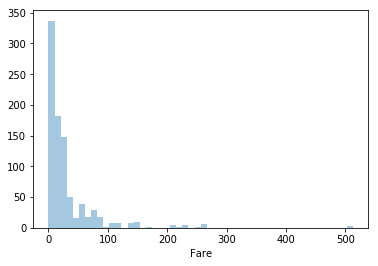

In [13]:
sns.distplot(train_df.Fare, kde=False)

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Fare, dtype: object

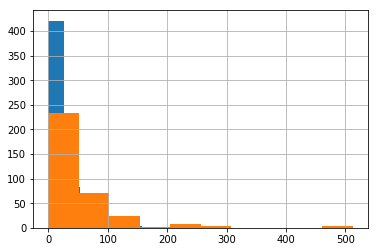

In [14]:
# Group by Survived, trace histograms of Fare with alpha color 0.6
train_df.groupby('Survived').Fare.hist(alpha=0.6)

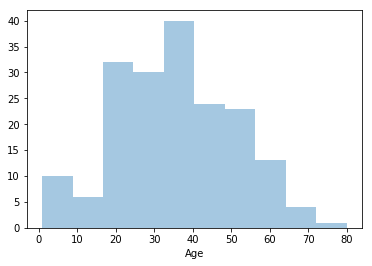

In [15]:
# There are a lot NaN in Age, so remove them
train_df_dropna = train_df.dropna()

sns.distplot(train_df_dropna.Age, kde=False)

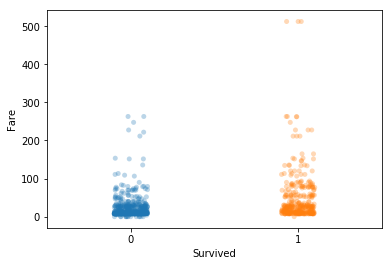

In [17]:
# Alternative to bars or scatter
sns.stripplot(x='Survived',
             y='Fare',
             data=train_df,
             alpha=0.3,
             jitter=True)

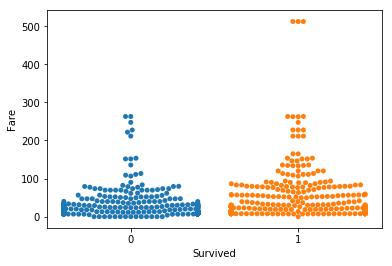

In [18]:
sns.swarmplot(x='Survived',
             y='Fare',
             data=train_df)

Take-away: Fare definitely seems to be correlated with survival aboard the Titanic.

In [19]:
# Group by Survived, describe Fare (descriptive statistics)
train_df.groupby('Survived').Fare.describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,22.117887,31.388207,0.0,7.8542,10.5,26.0,263.0000
1,342.0,48.395408,66.596998,0.0,12.4750,26.0,57.0,512.3292


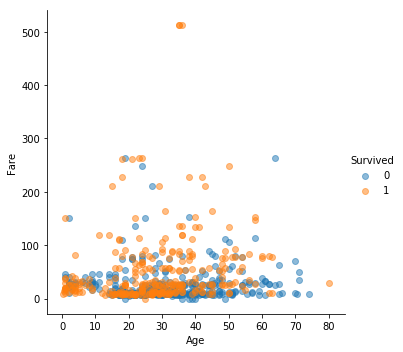

In [20]:
sns.lmplot(x='Age',
          y='Fare',
          hue='Survived',
          data=train_df,
          fit_reg=False,
          scatter_kws={'alpha':0.5})

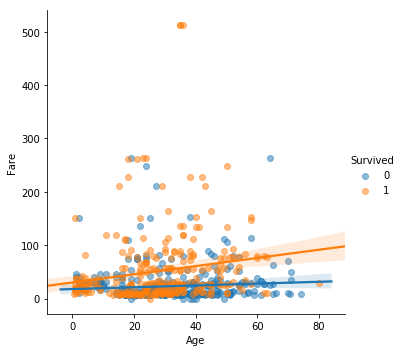

In [22]:
sns.lmplot(x='Age', 
           y='Fare', 
           hue='Survived', 
           data=train_df, 
           fit_reg=True, scatter_kws={'alpha':0.5})

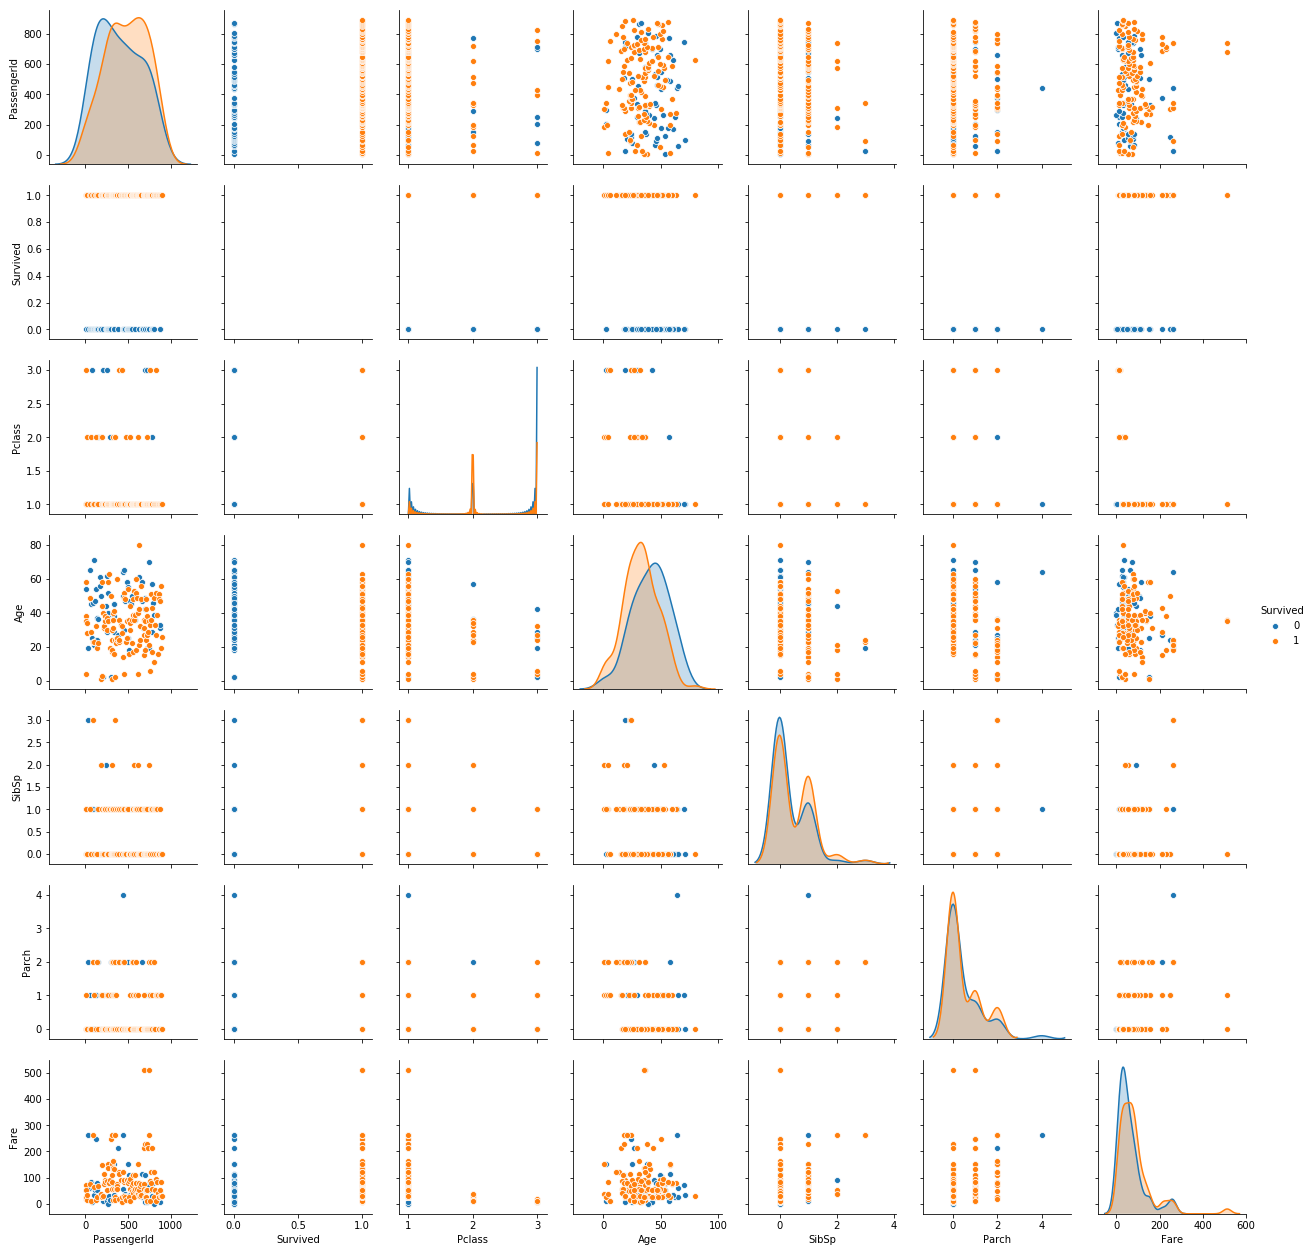

In [24]:
sns.pairplot(train_df_dropna, hue='Survived')

## Clean data

In [159]:
# find missing data
print train_df.isnull().sum()
print ''
print test_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [160]:
# fill Fare in test data
test_df.fillna(test_df['Fare'].mean(), inplace=True)

In [161]:
combi = train_df.append(test_df, ignore_index=True)
passenger_id = test_df['PassengerId']

combi.drop(['Ticket', 'Cabin'], axis=1, inplace=True)

combi['Sex'] = combi['Sex'].apply(lambda x: 0 if x == 'female' else 1)

In [162]:
# Name
# print combi['Name'].value_counts()
combi['Name'].head()

# for name_str in combi['Name']:
#     combi['Title'] = combi['Name'].str.extract('([A-Za-z]+)\.', expand=True)
combi['Title'] = combi['Name'].str.extract('([A-Za-z]+)\.', expand=True)
print combi['Title'].head()

#replacing the rare title with more common one.
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
combi.replace({'Title': mapping}, inplace=True)
print combi['Title'].head()
combi.drop(['Name'], axis=1, inplace=True)

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object
0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object


In [163]:
# impute missing Age
titles = ['Mr','Miss','Mrs','Master','Rev','Dr']
for title in titles:
    age_to_impute = combi.groupby('Title')['Age'].median()[titles.index(title)]
    combi.loc[ (combi['Age'].isnull()) & (combi['Title'] == title), 'Age'] = age_to_impute
    
combi.isnull().sum()

Age              0
Embarked         2
Fare             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Title            0
dtype: int64

In [164]:
# print len(train_df.Embarked.dropna().sum())
# print len(train_df.Embarked)

freq_port = train_df['Embarked'].dropna().mode()[0]
combi['Embarked'].fillna(freq_port, inplace=True)

combi['Embarked'] = combi['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
combi['Title'] = combi['Title'].map({'Mr': 0, 'Mrs':1, 'Miss':2, 'Master':3, 'Rev':4, 'Dr':5}).astype(int)

In [165]:
print combi.isnull().sum()
combi.fillna(0, inplace=True)
combi.info()

Age              0
Embarked         0
Fare             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Title            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
Age            1309 non-null float64
Embarked       1309 non-null int64
Fare           1309 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null int64
SibSp          1309 non-null int64
Survived       1309 non-null float64
Title          1309 non-null int64
dtypes: float64(3), int64(7)
memory usage: 102.3 KB


## Perform automated feature engineering
The entity is just a table with a uniquely identifying column known as an index. 

In [166]:
es = ft.EntitySet(id='titanic_data')

es = es.entity_from_dataframe(entity_id='combi', dataframe=combi.drop(['Survived'], axis=1),
                             variable_types=
                             {
                                 'Embarked': ft.variable_types.Categorical,
                                 'Sex': ft.variable_types.Boolean,
                                 'Title': ft.variable_types.Categorical
                             },
                             index='PassengerId')
print es

Entityset: titanic_data
  Entities:
    combi [Rows: 1309, Columns: 9]
  Relationships:
    No relationships


In [167]:
es = es.normalize_entity(base_entity_id='combi', new_entity_id='Embarked', index='Embarked')
es = es.normalize_entity(base_entity_id='combi', new_entity_id='Sex', index='Sex')
es = es.normalize_entity(base_entity_id='combi', new_entity_id='Title', index='Title')
es = es.normalize_entity(base_entity_id='combi', new_entity_id='Pclass', index='Pclass')
es = es.normalize_entity(base_entity_id='combi', new_entity_id='Parch', index='Parch')
es = es.normalize_entity(base_entity_id='combi', new_entity_id='SibSp', index='SibSp')
print es

Entityset: titanic_data
  Entities:
    Title [Rows: 6, Columns: 1]
    Embarked [Rows: 3, Columns: 1]
    Parch [Rows: 8, Columns: 1]
    Pclass [Rows: 3, Columns: 1]
    Sex [Rows: 2, Columns: 1]
    combi [Rows: 1309, Columns: 9]
    SibSp [Rows: 7, Columns: 1]
  Relationships:
    combi.Embarked -> Embarked.Embarked
    combi.Sex -> Sex.Sex
    combi.Title -> Title.Title
    combi.Pclass -> Pclass.Pclass
    combi.Parch -> Parch.Parch
    combi.SibSp -> SibSp.SibSp


In [168]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(primitives[primitives['type'] =='aggregation'].shape[0])

,name,type,description
0,count,aggregation,Counts the number of non null values.
1,std,aggregation,Finds the standard deviation of a numeric feature ignoring null values.
2,all,aggregation,Test if all values are 'True'.
3,last,aggregation,Returns the last value.
4,n_most_common,aggregation,Finds the N most common elements in a categorical feature.
5,min,aggregation,Finds the minimum non-null value of a numeric feature.
6,trend,aggregation,Calculates the slope of the linear trend of variable overtime.
7,max,aggregation,Finds the maximum non-null value of a numeric feature.
8,sum,aggregation,Sums elements of a numeric or boolean feature.
9,median,aggregation,Finds the median value of any feature with well-ordered values.


As we can see, the most of "transformation" functions are applied to datetime or time-dependent variables. In our dataset we do not have such variables. Therefore these functions will not be used.

In [169]:
primitives[primitives['type'] == 'transform'].head(primitives[primitives['type'] == 'transform'].shape[0])

,name,type,description
19,and,transform,"For two boolean values, determine if both values are 'True'."
20,cum_sum,transform,Calculates the sum of previous values of an instance for each value in a time-dependent entity.
21,months,transform,Transform a Timedelta feature into the number of months.
22,divide,transform,Creates a transform feature that divides two features.
23,cum_min,transform,Calculates the min of previous values of an instance for each value in a time-dependent entity.
24,is_null,transform,"For each value of base feature, return 'True' if value is null."
25,month,transform,Transform a Datetime feature into the month.
26,multiply,transform,Creates a transform feature that multplies two features.
27,second,transform,Transform a Datetime feature into the second.
28,year,transform,Transform a Datetime feature into the year.


1.Now we will apply a deep feature synthesis (dfs) function that will generate new features by automatically applying suitable aggregations, I selected a depth of 2. Higher depth values will stack more primitives.

In [170]:
features, feature_names = ft.dfs(entityset = es, 
                                 target_entity = 'combi',
                                max_depth = 2)

This is a list of new features. For example, "Title.SUM(combine.Age)" means the sum of Age values for each unique value of Title.

In [171]:
feature_names

[<Feature: Title>,
 <Feature: Fare>,
 <Feature: Pclass>,
 <Feature: Parch>,
 <Feature: Embarked>,
 <Feature: Sex>,
 <Feature: SibSp>,
 <Feature: Age>,
 <Feature: SibSp.MEAN(combi.Fare)>,
 <Feature: Pclass.STD(combi.Fare)>,
 <Feature: SibSp.STD(combi.Age)>,
 <Feature: Embarked.NUM_UNIQUE(combi.Parch)>,
 <Feature: SibSp.MAX(combi.Fare)>,
 <Feature: SibSp.MODE(combi.Embarked)>,
 <Feature: Pclass.MODE(combi.Title)>,
 <Feature: Pclass.NUM_UNIQUE(combi.Parch)>,
 <Feature: Embarked.MODE(combi.Title)>,
 <Feature: Parch.MIN(combi.Fare)>,
 <Feature: Title.SUM(combi.Fare)>,
 <Feature: Sex.MEAN(combi.Fare)>,
 <Feature: Title.MODE(combi.Parch)>,
 <Feature: Embarked.MIN(combi.Age)>,
 <Feature: Parch.SKEW(combi.Fare)>,
 <Feature: Title.NUM_UNIQUE(combi.Pclass)>,
 <Feature: Pclass.MEAN(combi.Fare)>,
 <Feature: Sex.STD(combi.Fare)>,
 <Feature: Title.SUM(combi.Age)>,
 <Feature: Sex.MEAN(combi.Age)>,
 <Feature: Embarked.MODE(combi.Pclass)>,
 <Feature: Parch.NUM_UNIQUE(combi.SibSp)>,
 <Feature: Parch.STD(

In [172]:
print len(feature_names)

146


In [173]:
features[features['Age'] == 22][['Title.SUM(combi.Age)', 'Age', 'Title']].head()

,Title.SUM(combi.Age),Age,Title
PassengerId,,,
1,27110.249744,22.0,0
61,27110.249744,22.0,0
81,27110.249744,22.0,0
113,27110.249744,22.0,0
142,5422.997827,22.0,2


By using "featuretools", we were able to generate 146 features just in a moment.

The "featuretools" is a powerful package that allows saving time to create new features from multiple tables of data. However, it does not completely subsitute the human domain knowledge. Additionally, now we are facing another problem known as the "curse of dimensionality".

### Determine collinear features

In [174]:
# Threshold for removing correlated variables
threshold = 0.95

# Absolute value correlation matrix
corr_matrix = features.corr().abs()
# np.trup: Upper triangle of an array.
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head(50)

,Title,Fare,Pclass,Parch,Embarked,Sex,SibSp,Age,SibSp.MEAN(combi.Fare),Pclass.STD(combi.Fare),...,Embarked.MEAN(combi.Fare),Pclass.MIN(combi.Fare),SibSp.MEAN(combi.Age),SibSp.SUM(combi.Fare),Embarked.SKEW(combi.Fare),SibSp.MODE(combi.Title),Embarked.SKEW(combi.Age),Title.MODE(combi.Embarked),Title.MEAN(combi.Age),Pclass.MODE(combi.Sex)
Title,NaN,0.133412,0.034855,0.266558,0.112932,0.593840,0.279670,0.404478,0.199607,0.014987,...,0.026367,NaN,0.303177,0.286565,0.073446,0.275320,0.092001,NaN,0.767628,NaN
Fare,NaN,NaN,0.558448,0.221506,0.061097,0.185458,0.160208,0.116484,0.225617,0.601343,...,0.298356,NaN,0.103008,0.181254,0.272334,0.063762,0.147657,NaN,0.075729,NaN
Pclass,NaN,NaN,NaN,0.018322,0.038875,0.124617,0.060832,0.295524,0.093210,0.897457,...,0.311981,NaN,0.099221,0.016411,0.327653,0.144339,0.063171,NaN,0.096299,NaN
Parch,NaN,NaN,NaN,NaN,0.095523,0.213125,0.373587,0.156980,0.330277,0.013431,...,0.021008,NaN,0.309783,0.354734,0.060831,0.288061,0.078224,NaN,0.228036,NaN
Embarked,NaN,NaN,NaN,NaN,NaN,0.120423,0.073461,0.018212,0.072664,0.048236,...,0.204778,NaN,0.052185,0.061908,0.212873,0.058530,0.951880,NaN,0.122193,NaN
Sex,NaN,NaN,NaN,NaN,NaN,NaN,0.109609,0.213492,0.192515,0.109088,...,0.035361,NaN,0.068827,0.139608,0.014953,0.025972,0.117979,NaN,0.406341,NaN
SibSp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.219485,0.710087,0.036056,...,0.030225,NaN,0.783283,0.896800,0.000483,0.773479,0.074680,NaN,0.289420,NaN
Age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.127933,0.307870,...,0.076193,NaN,0.280212,0.233786,0.068459,0.254943,0.040024,NaN,0.526920,NaN
SibSp.MEAN(combi.Fare),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.082322,...,0.067384,NaN,0.456560,0.803370,0.097587,0.282614,0.043410,NaN,0.128384,NaN
Pclass.STD(combi.Fare),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.344986,NaN,0.065560,0.006146,0.324248,0.096002,0.150839,NaN,0.076099,NaN


In [175]:
# Select columns with correlations above threshold
collinear_features = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d features to remove.' % (len(collinear_features)))

There are 77 features to remove.


In [176]:
features_filtered = features.drop(columns=collinear_features)

print('The number of features that passed the collinearity threshold: ', features_filtered.shape[1])

('The number of features that passed the collinearity threshold: ', 69)


### Detect the most relevant features using linear models penalized with the L1 norm

In [177]:
features_positive = features_filtered.loc[:, features_filtered.ge(0).all()]

In [178]:
train_X = features_positive[:train_df.shape[0]]
train_y = train_df['Survived']

test_X = features_positive[train_df.shape[0]:]

Since the number of features is smaller than the number of observations in "train_X", the parameter "dual" is equal to False.

In [179]:
lsvc = LinearSVC(C=0.01, penalty='l1', dual=False).fit(train_X, train_y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(train_X)
X_selected_df = pd.DataFrame(X_new, columns=[train_X.columns[i] for i in range(len(train_X.columns)) if model.get_support()[i]])
X_selected_df.shape

(891, 14)

In [180]:
print X_selected_df.columns

Index([                         u'Title',                           u'Fare',
                                  u'Age',         u'Pclass.STD(combi.Fare)',
                 u'SibSp.STD(combi.Age)',          u'SibSp.MAX(combi.Fare)',
       u'Pclass.NUM_UNIQUE(combi.Parch)',          u'SibSp.STD(combi.Fare)',
             u'Title.MODE(combi.Pclass)',  u'SibSp.NUM_UNIQUE(combi.Parch)',
                u'Title.MAX(combi.Fare)',            u'Sex.MAX(combi.Fare)',
                 u'Parch.MIN(combi.Age)',           u'Title.MIN(combi.Age)'],
      dtype='object')


### Training and testing the simple model 
Finally, we will create a basic random forest classifier with 2000 estimators. Please notice that I skip essential steps such as crossvalidation, the analysis of learning curves, etc.

In [181]:
random_forest = RandomForestClassifier(n_estimators=2000, oob_score=True)
random_forest.fit(X_selected_df, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [182]:
y_pred = random_forest.predict(test_X[X_selected_df.columns])

In [183]:
print y_pred

[0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0
 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0
 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0
 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 0 1 0 1 0 0 1 0 0 1]


In [184]:
my_submission = pd.DataFrame({'PassengerId': passenger_id, 'Survived': y_pred})
my_submission.to_csv('auto_ft_submission.csv', index=False)